In [4]:
import numpy as np
import healpy as hp
from astropy.io import fits
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
import pandas as pd

import astropy.coordinates as ac
from mpl_toolkits.basemap import Basemap

from gala.coordinates import MagellanicStreamNidever08
import matplotlib.pyplot as plt
import os
%matplotlib inline

# Load data and paths

In [5]:
plot_path = '/Users/mncavieres/Documents/2024-1/Delve/Plots/proposal'

In [6]:
giants = Table.read('/Users/mncavieres/Documents/2024-1/Delve/Data/giants_polygon_distances.fits')
giants

a_image_g,a_image_i,a_image_r,a_image_z,b_image_g,b_image_i,b_image_r,b_image_z,ccdnum_g,ccdnum_i,ccdnum_r,ccdnum_z,class_star_g,class_star_i,class_star_r,class_star_z,dec,ebv,expnum_g,expnum_i,expnum_r,expnum_z,exptime_g,exptime_i,exptime_r,exptime_z,extended_class_g,extended_class_i,extended_class_r,extended_class_z,extinction_g,extinction_i,extinction_r,extinction_z,flags_g,flags_i,flags_r,flags_z,hpx2048,htm9,mag_auto_g,mag_auto_i,mag_auto_r,mag_auto_z,mag_psf_g,mag_psf_i,mag_psf_r,mag_psf_z,magerr_auto_g,magerr_auto_i,magerr_auto_r,magerr_auto_z,magerr_psf_g,magerr_psf_i,magerr_psf_r,magerr_psf_z,nepochs_g,nepochs_i,nepochs_r,nepochs_z,nest4096,quick_object_id,ra,random_id,ring256,spread_model_g,spread_model_i,spread_model_r,spread_model_z,spreaderr_model_g,spreaderr_model_i,spreaderr_model_r,spreaderr_model_z,t_eff_g,t_eff_i,t_eff_r,t_eff_z,theta_image_g,theta_image_i,theta_image_r,theta_image_z,wavg_flags_g,wavg_flags_i,wavg_flags_r,wavg_flags_z,wavg_mag_auto_g,wavg_mag_auto_i,wavg_mag_auto_r,wavg_mag_auto_z,wavg_mag_psf_g,wavg_mag_psf_i,wavg_mag_psf_r,wavg_mag_psf_z,wavg_magerr_auto_g,wavg_magerr_auto_i,wavg_magerr_auto_r,wavg_magerr_auto_z,wavg_magerr_psf_g,wavg_magerr_psf_i,wavg_magerr_psf_r,wavg_magerr_psf_z,wavg_magrms_auto_g,wavg_magrms_auto_i,wavg_magrms_auto_r,wavg_magrms_auto_z,wavg_magrms_psf_g,wavg_magrms_psf_i,wavg_magrms_psf_r,wavg_magrms_psf_z,wavg_spread_model_g,wavg_spread_model_i,wavg_spread_model_r,wavg_spread_model_z,wavg_spreaderr_model_g,wavg_spreaderr_model_i,wavg_spreaderr_model_r,wavg_spreaderr_model_z,wavg_spreadrms_model_g,wavg_spreadrms_model_i,wavg_spreadrms_model_r,wavg_spreadrms_model_z,mjd_obs,elon,elat,glon,glat,on_sky_distance_arcsec,SOURCEID,CUEVENTID,FRAMESETID,RA2000,DEC2000,L,B,LAMBDA,ETA,PRIORSEC,YMJPNT,YMJPNTERR,JMHPNT,JMHPNTERR,HMKSPNT,HMKSPNTERR,JMKSPNT,JMKSPNTERR,YMJEXT,YMJEXTERR,JMHEXT,JMHEXTERR,HMKSEXT,HMKSEXTERR,JMKSEXT,JMKSEXTERR,MERGEDCLASSSTAT,MERGEDCLASS,PSTAR,PGALAXY,PNOISE,PSATURATED,EBV,AY,AJ,AH,AKS,YMJD,YPETROMAG,YPETROMAGERR,YPSFMAG,YPSFMAGERR,YSERMAG2D,YSERMAG2DERR,YAPERMAG3,YAPERMAG3ERR,YAPERMAG4,YAPERMAG4ERR,YAPERMAG6,YAPERMAG6ERR,YAPERMAGNOAPERCORR3,YAPERMAGNOAPERCORR4,YAPERMAGNOAPERCORR6,YHLCORSMJRADAS,YGAUSIG,YELL,YPA,YERRBITS,YAVERAGECONF,YCLASS,YCLASSSTAT,YPPERRBITS,YSEQNUM,YXI,YETA,JMJD,JPETROMAG,JPETROMAGERR,JPSFMAG,JPSFMAGERR,JSERMAG2D,JSERMAG2DERR,JAPERMAG3,JAPERMAG3ERR,JAPERMAG4,JAPERMAG4ERR,JAPERMAG6,JAPERMAG6ERR,JAPERMAGNOAPERCORR3,JAPERMAGNOAPERCORR4,JAPERMAGNOAPERCORR6,JHLCORSMJRADAS,JGAUSIG,JELL,JPA,JERRBITS,JAVERAGECONF,JCLASS,JCLASSSTAT,JPPERRBITS,JSEQNUM,JXI,JETA,HMJD,HPETROMAG,HPETROMAGERR,HPSFMAG,HPSFMAGERR,HSERMAG2D,HSERMAG2DERR,HAPERMAG3,HAPERMAG3ERR,HAPERMAG4,HAPERMAG4ERR,HAPERMAG6,HAPERMAG6ERR,HAPERMAGNOAPERCORR3,HAPERMAGNOAPERCORR4,HAPERMAGNOAPERCORR6,HHLCORSMJRADAS,HGAUSIG,HELL,HPA,HERRBITS,HAVERAGECONF,HCLASS,HCLASSSTAT,HPPERRBITS,HSEQNUM,HXI,HETA,KSMJD,KSPETROMAG,KSPETROMAGERR,KSPSFMAG,KSPSFMAGERR,KSSERMAG2D,KSSERMAG2DERR,KSAPERMAG3,KSAPERMAG3ERR,KSAPERMAG4,KSAPERMAG4ERR,KSAPERMAG6,KSAPERMAG6ERR,KSAPERMAGNOAPERCORR3,KSAPERMAGNOAPERCORR4,KSAPERMAGNOAPERCORR6,KSHLCORSMJRADAS,KSGAUSIG,KSELL,KSPA,KSERRBITS,KSAVERAGECONF,KSCLASS,KSCLASSSTAT,KSPPERRBITS,KSSEQNUM,KSXI,KSETA,PRIMARY_SOURCE,g_i,i_Ks,gmag,dist_1,g_ABS_1,dist_2,g_ABS_2,dist_3,g_ABS_3,dist_4,g_ABS_4
float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,f

In [7]:
isochrone_lcm_halo = pd.read_csv('/Users/mncavieres/Documents/2024-1/Delve/Data/isochrones/-0.9dex_10Gyr.csv')

## Add Magellanic Coordinates

In [8]:
# Step 1: Convert RA/Dec to a SkyCoord object
coords = SkyCoord(ra=giants['ra']*u.deg, dec=giants['dec']*u.deg, frame='icrs')

# Step 2: Convert RA/Dec to Magellanic Stream Coordinates
mag_stream_coords = coords.transform_to(MagellanicStreamNidever08())

# Add the new coordinates to the table
giants['L_stream'] = mag_stream_coords.L.degree
giants['B_stream'] = mag_stream_coords.B.degree


In [6]:
giants.write('/Users/mncavieres/Documents/2024-1/Delve/Data/giants_polygon_distances_streamcoords.fits', overwrite=True)

# Select stars

The goal here is to select stars that lie between the isochrone when placing it at two different distances. This requires first to select the RGB of the isochrone, then to fit a polynomial to it, and then select stars that lie between that polynomial and the offset polynomial for the other distance.

In [9]:
# select RGB in isochrone
isochrone_lmc_rgb = isochrone_lcm_halo.loc[(isochrone_lcm_halo['label'] == 3)]

In [10]:
# fit polynomial to the isochrone in the CMD
coeffs = np.polyfit(isochrone_lmc_rgb['gmag']-isochrone_lmc_rgb['imag'], isochrone_lmc_rgb['gmag'], 5)

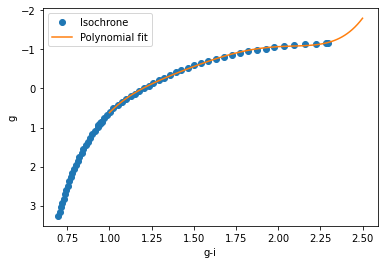

In [11]:
# plot resulting polynomial
x = np.linspace(1, 2.5, 100)
y = np.polyval(coeffs, x)

plt.plot(isochrone_lmc_rgb['gmag']-isochrone_lmc_rgb['imag'], isochrone_lmc_rgb['gmag'], 'o', label='Isochrone')
plt.plot(x, y, label='Polynomial fit')
plt.xlabel('g-i')
plt.ylabel('g')
plt.gca().invert_yaxis()
plt.legend()
plt.savefig(os.path.join(plot_path, 'isochrone_fit.png'))
plt.show()

In [12]:
# define function to get RGB at a given distance
def rgb_at_distance(distance, coeffs = coeffs):
    return lambda x: np.polyval(coeffs, x) + 5*np.log10(distance/10)

# define function that returns only points that lie between two polynomials
def filter_points_between_polys_astropy(data, x_col, y_col, poly1, poly2):
    """
    Filters and returns points from an Astropy Table that lie between two polynomials.

    Args:
        data: Astropy Table containing the data to be filtered.
        x_col: Name of the column containing X values.
        y_col: Name of the column containing Y values.
        poly1: Function that defines the first polynomial (takes X and returns Y).
        poly2: Function that defines the second polynomial (takes X and returns Y).

    Returns:
        Filtered data as an Astropy Table containing only the points between the two polynomials.
    """
    # Extract the X and Y columns from the table
    x_data = data[x_col]
    y_data = data[y_col]

    # Arrays to store the filtered data
    filtered_rows = []

    # Iterate through each point and apply the filtering
    for i, (x, y) in enumerate(zip(x_data, y_data)):
        poly1_val = poly1(x)
        poly2_val = poly2(x)

        # Determine the lower and upper bounds
        lower_bound = min(poly1_val, poly2_val)
        upper_bound = max(poly1_val, poly2_val)

        # Check if the point is between the two polynomial bounds
        if lower_bound <= y <= upper_bound:
            filtered_rows.append(i)

    # Return the filtered rows as a new Astropy table
    return data[filtered_rows]

## Set the distance regime for the selection in pc

In [13]:
# select stars between two isochrones at a given distance range
distance_range = [40000, 80000]
filtered_stars = filter_points_between_polys_astropy(giants[giants['glat'] < 0], x_col = 'g_i', y_col = 'gmag',
                                            poly1=rgb_at_distance(distance=distance_range[0]),
                                             poly2=rgb_at_distance(distance=distance_range[1])) 

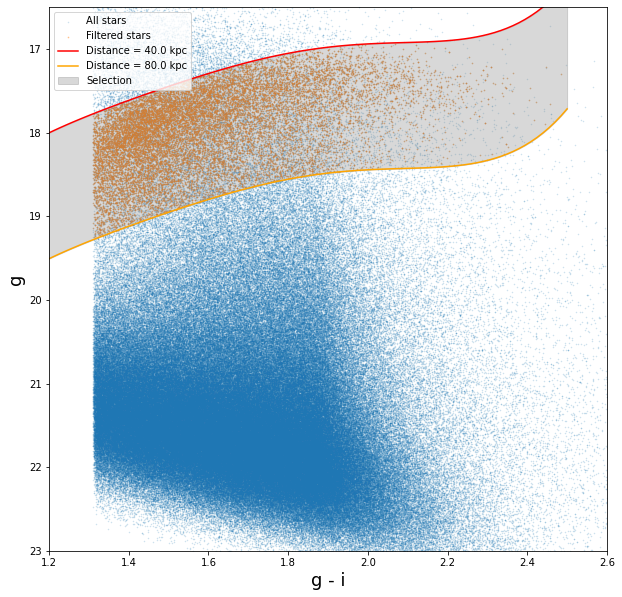

In [17]:
# plot the filtered stars and the isochrone and the two polynomials and all stars
#plt.plot(isochrone_lmc_rgb['gmag']-isochrone_lmc_rgb['imag'], isochrone_lmc_rgb['gmag'], 'o', label='Isochrone')
plt.figure(figsize=(10, 10))
x = np.linspace(1, 2.5, 100)
plt.scatter(giants['g_i'], giants['gmag'], s=0.3, label='All stars', alpha=0.2)
plt.scatter(filtered_stars['g_i'], filtered_stars['gmag'], s=0.5, label='Filtered stars', alpha=0.4)
plt.plot(x, rgb_at_distance(distance=distance_range[0])(x), label=f'Distance = {distance_range[0]/1e3} kpc', color='red')
plt.plot(x, rgb_at_distance(distance=distance_range[1])(x), label=f'Distance = {distance_range[1]/1e3} kpc', color='orange')
#plt.plot(x, rgb_at_distance(distance=62000)(x), label=f'Distance = {62} kpc', color='green')
# Shade the area between the two curves
plt.fill_between(x, y_distance_1, y_distance_2, color='gray', alpha=0.3, label='Selection')

plt.xlabel('g - i', fontsize=18)
plt.ylabel('g', fontsize=18)
plt.gca().invert_yaxis()
plt.ylim(23, 16.5)
plt.xlim(1.2, 2.6)
plt.legend(loc = 'upper left')
plt.savefig(os.path.join(plot_path, 'filtered_stars_good_3.png'))
plt.show()

## Colored by density

In [14]:
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap

/Users/mncavieres/opt/anaconda3/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/Users/mncavieres/opt/anaconda3/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


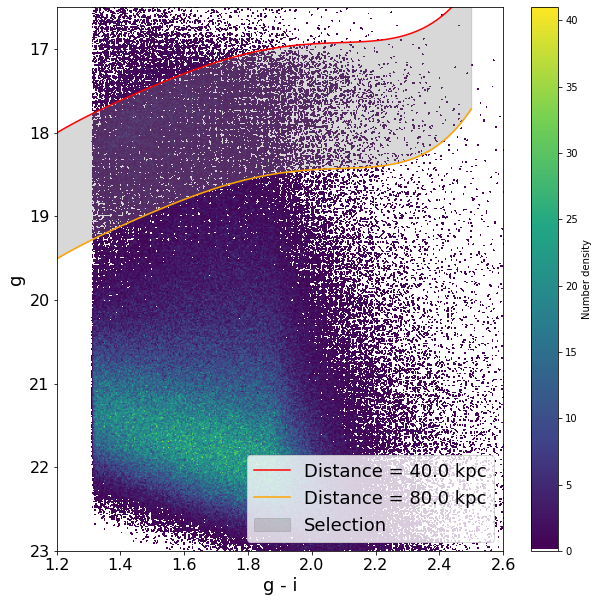

In [15]:
# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

def using_mpl_scatter_density(fig, x, y, label):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y, cmap=white_viridis)
    fig.colorbar(density, label='Number density')
    ax.set_xlabel('g - i', fontsize=18)
    ax.set_ylabel('g', fontsize=18)
    ax.invert_yaxis()  # Invert y-axis as in your original script
    ax.set_ylim(23, 16.5)
    ax.set_xlim(1.2, 2.6)
    ax.legend([label], loc='upper left')

# Set up the data for plotting
x_gi_all = giants['g_i']  # All stars' g - i color
y_gmag_all = giants['gmag']  # All stars' g magnitude

x_gi_filtered = filtered_stars['g_i']  # Filtered stars' g - i color
y_gmag_filtered = filtered_stars['gmag']  # Filtered stars' g magnitude

# Create figure for density plot
fig = plt.figure(figsize=(10, 10))
using_mpl_scatter_density(fig, x_gi_all, y_gmag_all, label='All stars')

# Overlay filtered stars using a different density plot
#using_mpl_scatter_density(fig, x_gi_filtered, y_gmag_filtered, label='Filtered stars')

# Plot polynomials (distance curves)
x = np.linspace(1, 2.5, 100)

# Compute the y values for the two distance curves
y_distance_1 = rgb_at_distance(distance=distance_range[0])(x)
y_distance_2 = rgb_at_distance(distance=distance_range[1])(x)

plt.plot(x, rgb_at_distance(distance=distance_range[0])(x), label=f'Distance = {distance_range[0]/1e3} kpc', color='red')
plt.plot(x, rgb_at_distance(distance=distance_range[1])(x), label=f'Distance = {distance_range[1]/1e3} kpc', color='orange')


# Shade the area between the two curves
plt.fill_between(x, y_distance_1, y_distance_2, color='gray', alpha=0.3, label='Selection')

# increase x and y axis ticks font size
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(loc='lower right', fontsize=18)
# Save and display the plot
plt.savefig(os.path.join(plot_path, 'filtered_stars_density_2.png'))
plt.show()

## Save results

In [36]:
# select stars at low latitude
filtered_stars = filtered_stars[filtered_stars['glat'] < 0]

In [37]:
# save the filtered stars
filtered_stars.write('/Users/mncavieres/Documents/2024-1/Delve/Data/filtered_stars_0.9dex_4.fits', overwrite=True)

# Make mollwide plot

In [22]:
def mollweide_plot(giants, ra_col='RA', dec_col='Dec'):
    """
    Creates a Mollweide projection plot of stars using RA and Dec from an Astropy table.

    Args:
        giants: Astropy Table containing the RA and Dec data of stars.
        ra_col: The column name for Right Ascension (RA) in the table (default 'RA').
        dec_col: The column name for Declination (Dec) in the table (default 'Dec').
    """
    # Extract RA and Dec from the table
    ra = giants[ra_col]
    dec = giants[dec_col]

    # Convert RA from degrees to radians and shift it to the range [-180, 180] in degrees
    ra = np.deg2rad(ra)  # Convert to radians
    ra = np.remainder(ra + 2 * np.pi, 2 * np.pi)  # Wrap RA to [0, 2π] range
    ra = ra - np.pi  # Shift to [-π, π] for Mollweide projection

    # Convert Dec from degrees to radians
    dec = np.deg2rad(dec)

    # Create the Mollweide projection plot
    plt.figure(figsize=(10, 5))
    ax = plt.subplot(111, projection='mollweide')

    # Plot the points
    ax.scatter(ra, dec, s=1, color='blue', alpha=0.5)  # s=1 is the marker size, adjust as needed

    # Set the grid and labels
    ax.grid(True)
    ax.set_xlabel('RA (radians)', fontsize=12)
    ax.set_ylabel('Dec (radians)', fontsize=12)

    # Convert RA ticks from radians to hours for readability
    tick_labels = np.array(['14h', '16h', '18h', '20h', '22h', '0h', '2h', '4h', '6h', '8h', '10h'])
    ax.set_xticklabels(tick_labels)

    # Show the plot
    plt.title("Mollweide Projection of RA/Dec Coordinates")
    plt.show()
   

def aitoff_plot(tables, ra_col='ra', dec_col='dec', labels=None, colors=None, title="Aitoff Projection", xlim_deg=None, ylim_deg=None, **kwargs):
    """
    Creates an Aitoff projection plot with multiple datasets.

    Args:
        tables: List of Astropy Tables to plot.
        ra_col: The column name for RA (Right Ascension) in each table.
        dec_col: The column name for Dec (Declination) in each table.
        labels: List of labels for the legend (optional, same length as `tables`).
        colors: List of colors for each table plot (optional, same length as `tables`).
        title: Title for the plot.
        xlim_deg: Tuple for the X-axis limits in degrees (optional, will be converted to radians).
        ylim_deg: Tuple for the Y-axis limits in degrees (optional, will be converted to radians).
        **kwargs: Additional keyword arguments to pass to matplotlib (e.g., xlim, ylim).
    """
    # Create the Aitoff projection plot
    plt.figure(figsize=(10, 5))
    ax = plt.subplot(111, projection='aitoff')

    # Loop over each table and plot the data
    for i, table in enumerate(tables):
        # Convert RA and Dec to radians
        ra = np.deg2rad(table[ra_col])
        dec = np.deg2rad(table[dec_col])

        # Wrap RA around to [-π, π] (like you do for Mollweide or Aitoff)
        ra = np.remainder(ra + 2 * np.pi, 2 * np.pi)
        ra = ra - np.pi

        # Invert RA by multiplying by -1
        ra = -ra

        # Determine color and label for each dataset
        color = colors[i] if colors is not None else f'C{i}'  # Use given color or default to C0, C1, etc.
        label = labels[i] if labels is not None else f"Dataset {i+1}"  # Use given label or default to "Dataset 1", etc.

        # Plot the data
        ax.scatter(ra, dec, s=1, color=color, label=label, alpha=0.7)

    # Add legend
    plt.legend(loc='upper right')

    # Set the grid and labels
    ax.grid(True)
    ax.set_xlabel('RA (radians)', fontsize=12)
    ax.set_ylabel('Dec (radians)', fontsize=12)

    # Apply limits in degrees if provided
    if xlim_deg is not None:
        xlim_rad = np.deg2rad(xlim_deg)  # Convert xlim from degrees to radians
        ax.set_xlim(xlim_rad)
    if ylim_deg is not None:
        ylim_rad = np.deg2rad(ylim_deg)  # Convert ylim from degrees to radians
        ax.set_ylim(ylim_rad)

    # Apply additional kwargs like xlim, ylim, etc. (in radians)
    if 'xlim' in kwargs:
        ax.set_xlim(kwargs['xlim'])
    if 'ylim' in kwargs:
        ax.set_ylim(kwargs['ylim'])
    
    # Set the title
    plt.title(title)

    # Show the plot
    #plt.show()



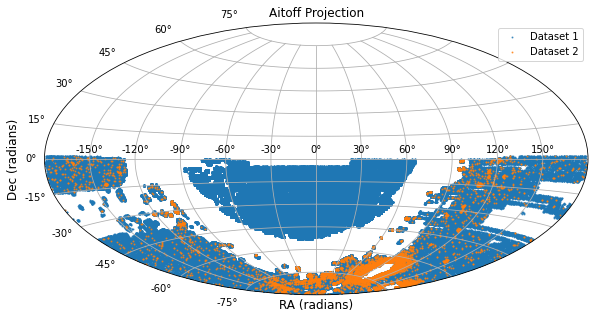

In [38]:
aitoff_plot([giants, filtered_stars], ra_col='ra', dec_col='dec')
#plt.savefig(os.path.join(plot_path, 'aitoff_plot.pdf'))

In [198]:
import ligo.skymap.plot

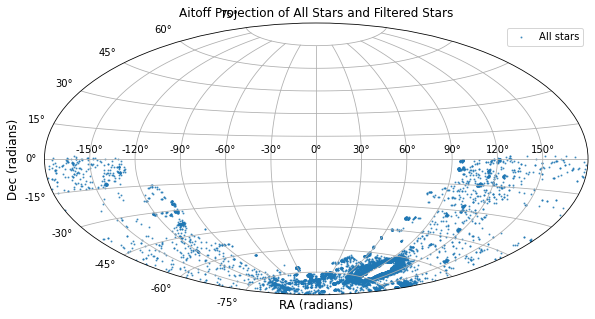

In [212]:
aitoff_plot([ filtered_stars], ra_col='ra', dec_col='dec', labels=['All stars', 'Filtered stars'],
             title='Aitoff Projection of All Stars and Filtered Stars' )

# axesinset = plt.axes(
#     [0.0, 0.0, 0.4, 0.4], 
#     projection='astro degrees zoom', 
#     center='0deg -60deg', 
#     radius='20 deg' )
# plt.sca(axesinset)
# axesinset.invert_xaxis()
# axesinset.scatter(filtered_stars['ra'], 100+filtered_stars['dec'], s=1, color='blue', alpha=0.5)
# #axesinset.contour(X, Y, skypost, colors='blue', levels=[5, 50, 95])

# axesinset.grid()
plt.show()

# Only consider stars between $\pm 20 deg$ from the MS

In [279]:
filtered_stars_ms_cord = filtered_stars[(filtered_stars['B_stream'] < 30)& (filtered_stars['B_stream'] > -30)& (filtered_stars['L_stream'] > -150) & (filtered_stars['L_stream'] < -20)]

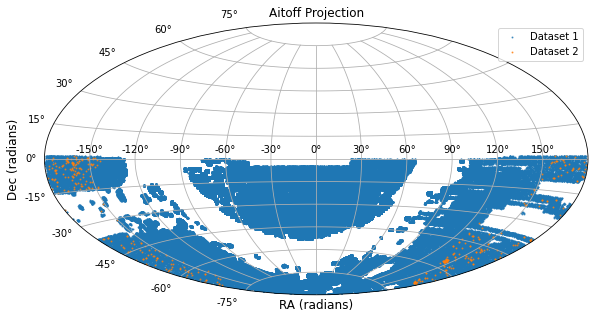

In [280]:
aitoff_plot([giants, filtered_stars_ms_cord], ra_col='ra', dec_col='dec')


# Make Magellanic coordinate system plot

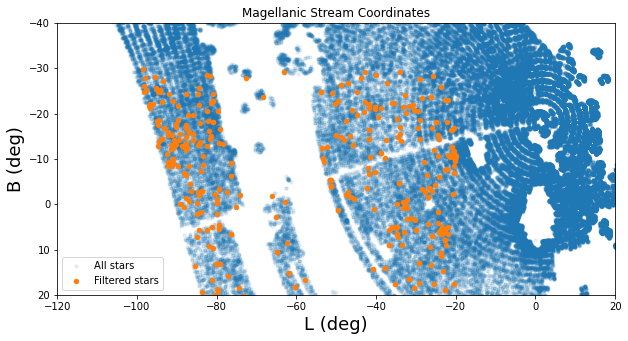

In [281]:
plt.figure(figsize=(10, 5))
plt.scatter(giants['L_stream'], giants['B_stream'], s=10, label='All stars', alpha=0.1)
plt.scatter(filtered_stars_ms_cord['L_stream'], filtered_stars_ms_cord['B_stream'], s=20, label='Filtered stars', alpha=1)
plt.xlabel('L (deg)', fontsize=18)
plt.ylabel('B (deg)', fontsize=18)
plt.legend()
plt.title('Magellanic Stream Coordinates')
plt.xlim(-120, 20)
plt.ylim(20, -40)
#plt.gca().invert_yaxis()
plt.savefig(os.path.join(plot_path, 'stream_coord.pdf'))
plt.show()

In [282]:
filtered_stars_ms_cord.write('/Users/mncavieres/Documents/2024-1/Delve/Data/filtered_stars_ms_cord.fits', overwrite=True)